In [1]:
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
library(broom)
library(rvest)
library(infer)
library(cowplot)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 10 rows

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Project Final Report

## Introduction

#### General Information
This Final Report will be conducted on datasets provided by a research group in Computer Science at UBC, led by Frank Wood, in which the research group collected data about how players play video games. The datasets provided include `players.csv`, which provides the general information about each participant, and `sessions.csv`, which provides individual session information from each player.  

#### Aim

The aim of this final report is to gain relevant information regarding two questions. Firstly a broad question
* Which player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

and secondly, a more specific question
* How accurately can just age and just hours played predict subscription to a game-related newsletter compared to a prediction using both age and hours played in `players.csv`?

The purpose of our investigation is to assist the researchers and their stakeholders in understanding how important age is in subscribing to a game-related newsletter. By looking at how hours played on the server changes our predictive model, we hope to gain insight on whether or not age can be a reliable predictor independently for whether or not someone will subscribe to the newsletter.   

#### Datasets

As stated in our specific question, we will be working on the dataset `players.csv`. 

#### Data Characteristics  
The `players.csv` is populated by data collect from players when they sign-up to play on the minecraft server. It represents 196 individuals who participated in the study, described by 7 features, including:
* `experience <chr>` - Player's experience
* `subscribe <lgl>` - Whether the player subscribed to the newsletter
* `hashedEmail <chr>` - Unique identifier for each player
* `played_hours <dbl>` - Total hours played
* `name <chr>` - First Name
* `gender <chr>` - Gender
* `age <dbl>` - Age in years

##### Data Summary
* `experience` is composed of
    * 17.9% `Beginner`
    * 32.1% `Amateur`
    * 18.4% `Regular`
    * 24.5% `Veteran`
    * 7.1% `Pro`
* `subscribe` is composed of 144 `TRUE` and 52 `FALSE`  
* `gender` is composed of
    * 63.3% `Male`
    * 18.9% `Female`
    * 7.7% `Non-binary`
    * 3.1% `Two-Spirited`
    * 1.0% `Agender`
    * 0.5% `Other`
    * 5.6% `Prefer not to say`
* `played_hours`
    * Maximum - 223.1 hours
    * Minimum - 0 hours
    * Average - 5.845918 Hours
* `Age`
    * Oldest - 50 years
    * Youngest - 8 years
    * Mean - 20.52 years


##### Potential Issues
* Column `Age` contains `NA`
* Dataset is male dominated
* Dataset is majority Amateur players
* Order of experience not specified, we will be assuming `Beginner -> Amateur -> Regular -> Pro -> Veteran`

In [54]:
## SUMMARY DATA GENERATION METHODS
options(dplyr.print_max = 10)

url <- "https://raw.githubusercontent.com/ckwok07/DSCI-100-Project-Final-Report/refs/heads/main/data/players.csv"
summary_players <- read_csv(url)
summary_players

total_entries <- nrow(summary_players)
total_entries

experience_demographic <- summary_players |>
    group_by(experience) |>
    summarize(proportion = n() / total_entries)
print(experience_demographic)

gender_demographic <- summary_players |>
    group_by(gender) |>
    summarize(proportion = n() / total_entries)
print(gender_demographic)

max_played_hours <- summary_players |>
    summarize(max_hours = max(played_hours)) |>
    pull()
max_played_hours

min_played_hours <- summary_players |>
    summarize(min_hours = min(played_hours)) |>
    pull()
min_played_hours

mean_played_hours <- summary_players |>
    summarize(mean_hours = mean(played_hours)) |>
    pull()
mean_played_hours

max_age <- summary_players |>
    summarize(max_age = max(Age, na.rm = TRUE)) |>
    pull()
max_age

min_age <- summary_players |>
    summarize(min_age = min(Age, na.rm = TRUE)) |>
    pull()
min_age

mean_age <- summary_players |>
    summarize(mean_age = mean(Age, na.rm = TRUE)) |>
    pull()
mean_age

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


[1] 196

# A tibble: 5 × 2
  experience proportion
  <chr>           <dbl>
1 Amateur        0.321 
2 Beginner       0.179 
3 Pro            0.0714
4 Regular        0.184 
5 Veteran        0.245 
# A tibble: 7 × 2
  gender            proportion
  <chr>                  <dbl>
1 Agender              0.0102 
2 Female               0.189  
3 Male                 0.633  
4 Non-binary           0.0765 
5 Other                0.00510
6 Prefer not to say    0.0561 
7 Two-Spirited         0.0306 


[1] 223.1

[1] 0

[1] 5.845918

[1] 50

[1] 8

[1] 20.52062

## Methods and Results

Our specific question is primarily a predictive data analysis question. We are looking to determine if just `age` or just `played_hours` can predict whether a player will subscribe to a video game newsletter more accurately then both `age` and `played_hours` can. Because `subscribe` has two categories, `TRUE` if the player subscribed to a video game newsletter or `FALSE` if the player didn't, we can separately analyze the accuracy of using `age` as to predict `subscription`, using `played_hours` to predict `subscription` and using both `age` and `played_hours` to predict `subscription`.  

In order to determine which classification method we should use, we need to first wrangle and tidy the data, then look at data visualizations regarding `age` and `played_hours`.

In [2]:
# Reading and viewing the players.csv data
url <- "https://raw.githubusercontent.com/ckwok07/DSCI-100-Project-Final-Report/refs/heads/main/data/players.csv"
players <- read_csv(url)
# Checking for NA values in Age
players_age_na <- players |>
    filter(is.na(Age))
players_age_na

# Checking for NA values in played_hours
players_played_na <- players |>
    filter(is.na(played_hours))
#players_played_na

# Checking for NA values in experience
players_experience_na <- players |>
    filter(is.na(experience))
#players_experience_na

# Checking for NA values in subscribe
players_subscribe_na <- players |>
    filter(is.na(subscribe))
#players_subscribe_na

# Thus only the Age column has NA values. In addition to that, because the amount of NA values in Age is relatively small, 
# we can remove them from the dataset instead of imputing the individuals' age as dropping these two players will not impact
# the dataset very much.

# Removing the NA values of age from the dataframe
players <- players |>
    filter(!is.na(Age))

#In addition to that, we must turn the subscribe column into a factor data type as it has 2 categories that we are going to predict
players <- players |>
    mutate(subscribe = as.factor(subscribe))
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


**(Figure 0)** : _The top dataframe shows `players.csv` where `Age` is not specified or `NA`. The bottom dataframe shows `players.csv` after removing `NA` values and is tidy._

Once our data is wrangled and tidy, we can visualize the relationships between `age` and `subscribe` as well as the relationship between `played_hours` and `subscribe`

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


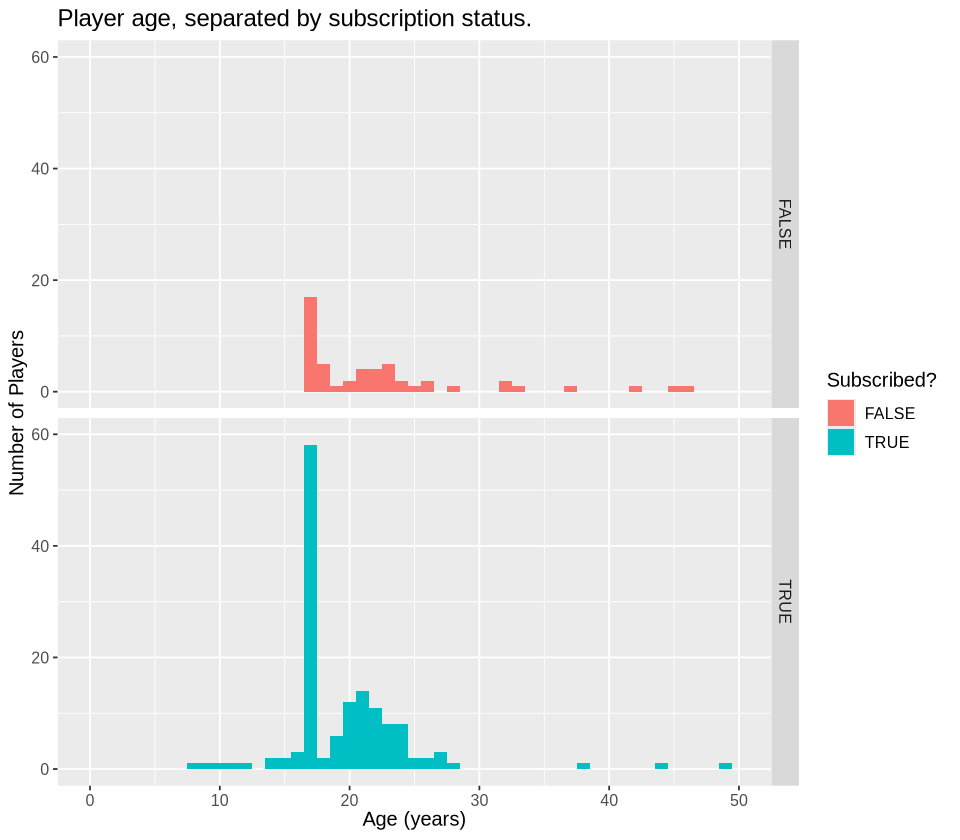

In [3]:
options(repr.plot.width = 8, repr.plot.height = 7)

# Histogram visualization of the relationship between age and subscribe
players_age_subscribe_plot <- players |>
    ggplot(aes(x = Age, fill = subscribe)) +
    geom_histogram(binwidth = 1) +
    facet_grid(rows = vars(subscribe)) +
    labs(title = "Player age, separated by subscription status.", x = "Age (years)" , y = "Number of Players", fill = "Subscribed?") +
    xlim(c(0, 50)) +
    ylim(c(0,60)) +
    theme(text = element_text(size = 12))
players_age_subscribe_plot

**(Figure 1)**: Two histograms that display the age distribution of players who subscribed to a video game newsletter and those who did not. The x-axis indicates the players age in years and the y-axis indicates the number of players in each age. The top panel represents players in each age group who did not subscribe, while the bottom panel represents players in each group who did subscribe._

From **Figure 1**, we can analyze the relationship between `Age` and `subscribe` in the `players.csv` dataset. In the `subscribe = TRUE` portion of the visualization, at first glance, it seems that as `age` increases, number of players subscribing to a video game newsletter decreases. However, this is not the case, because if it were, then the number of players not subscribed as age increases would be increasing, which is not reflected in the `subscribe = FALSE` portion of **Figure 1**.  Thus, there doesn't seem to be a distinct relationship shape between age and number of people subscribing to a video game newsletter.

Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


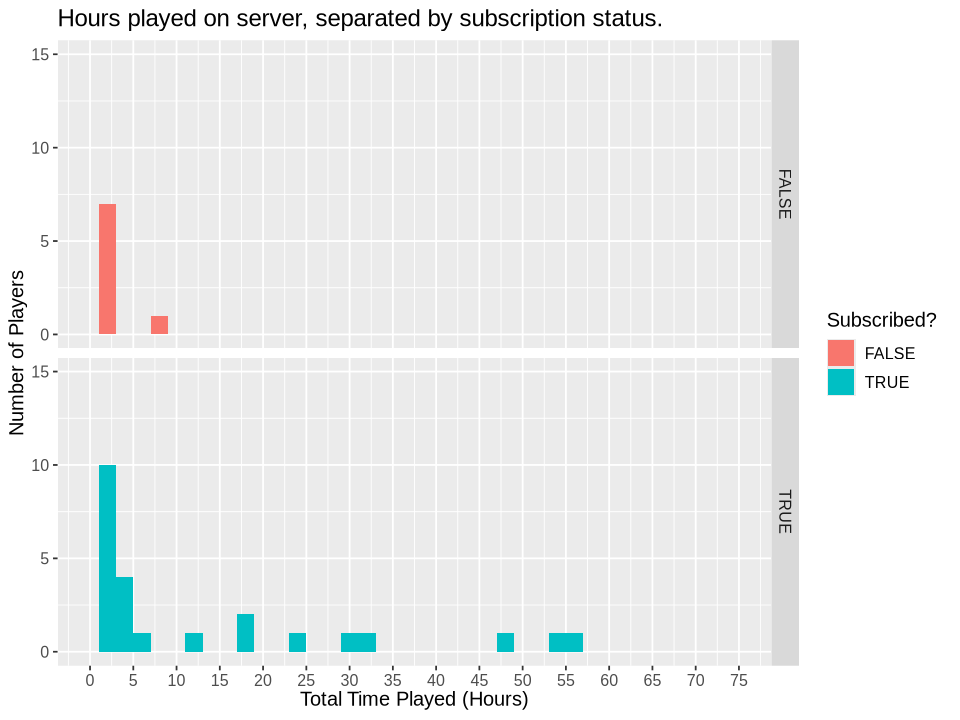

In [4]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Histogram visualization of the relationship between played_hours and subscribe
players_played_hours_subscribe_plot <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(binwidth = 2) +
    facet_grid(rows = vars(subscribe)) +
    labs(title = "Hours played on server, separated by subscription status.", x = "Total Time Played (Hours)" , y = "Number of Players", fill = "Subscribed?") +
    scale_x_continuous(breaks = seq(0, 75, b = 5), limits = c(0, 75)) +
    ylim(c(0,15)) +
    theme(text = element_text(size = 12))
players_played_hours_subscribe_plot

**(Figure 2)** : _Two histograms that display the distribution of player's total time played who subscribed to a video game newsletter and those who did not. The x-axis indicates the total time played in hours and the y-axis indicates the number of players in each grouping of hours. The top panel represents players in each hours played group who did not subscribe, while the bottom panel represents players in each hours played group who did subscribe._

**Figure 2** indicates that while there is no minimum value of `played_hours` for a player to subscribe, all the players that are not subscribed to the newsletter have less than 10 hours played on the server.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


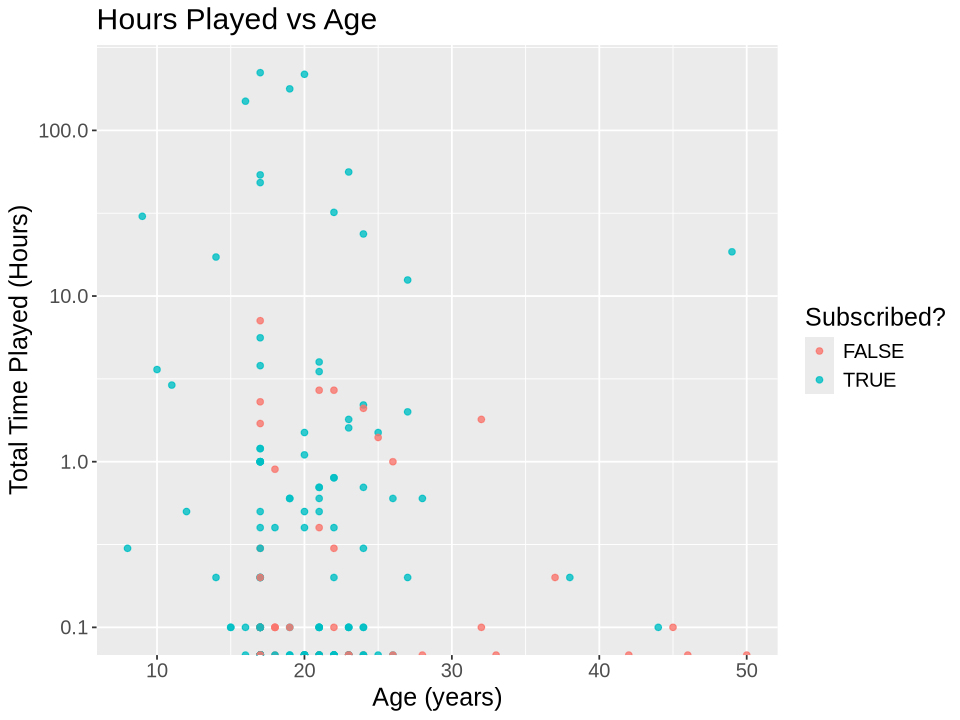

In [5]:
# Scatterplot visualization of the relationship between age, played_hours and subscribe
players_age_played_hours_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.8) + 
    labs(title = "Hours Played vs Age", x = "Age (years)", y = "Total Time Played (Hours)", color = "Subscribed?") +
    scale_y_log10() +
    theme(text = element_text(size = 15))
players_age_played_hours_plot

**(Figure 3)** : _A scatterplot that visualizes the relationship between `age` and `played_hours` colored by whether or not the player subscribed to a video game newsletter. Each point represents a player. The x-axis indicates the player's age in years while the y-axis indicates the player's total time played in hours on a logarithmic scale. Blue points indicate players who did subscribe and orange points indicate players who did not subscribe._

Because each predictor variable(s) have hard, indistinguishable relationships with `subscribe` we will perform KNN classification to predict whether or not a player will subscribe to a video game newsletter using only `Age`, only `played_hours`, and both `Age` and `played_hours` as predictors. This is because the KNN algorithm makes no assumptions about data distribution/relationship shape.  

In order to use KNN classification we will first split the dataset into 70% Training and 30% Testing sets. In addition to that, scaling, tuning and cross-validation will be performed to determine the most accurate k-value for our algorithms.

In [6]:
set.seed(1234) # Seed for possible recreation

# Splitting the players dataframe into training and testing sets
players_split <- initial_split(players, prop = 0.7, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

# Checking the proportions of FALSE and TRUE subscriptions in original dataframe
player_proportions <- players |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players))
player_proportions

# Checking the proportions of FALSE and TRUE subscriptions in training dataframe
player_training_proportions <- players_training |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players_training))
player_training_proportions

# Checking the proportions of FALSE and TRUE subscriptions in testing dataframe
player_testing_proportions <- players_testing |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players_testing))
player_testing_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,36,26.66667
TRUE,99,73.33333


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,16,27.11864
TRUE,43,72.88136


**(Figure 4)** : _Three dataframes showcasing the percentage of `TRUE`s and `FALSE`s. The first dataframe (top) showcases the percentages in **Figure 0**. The second dataframe (middle) showcases the ratio in our training set. The third dataframe (bottom) showcases the ratio in our testing set_

The ratio of `TRUE` and `FALSE` in the column `subscribe` are roughly the same for the original, training, and testing datasets. Thus we can begin training our classification model.

In [7]:
set.seed(1234) # Seed for possible recreation

# Creating our KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Specifying the number of folds in our cross-validation + which variable we are predicting
players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

# K-value tibble for cross validation
k_vals <- tibble(neighbors = seq(from = 1, to = 100))

In [8]:
set.seed(1234) # Seed for possible recreation

# Recipe using Age to predict subscription using the training data + scaling predictors
players_age_recipe <- recipe(subscribe ~ Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation.
knn_age_results <- workflow() |>
    add_recipe(players_age_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

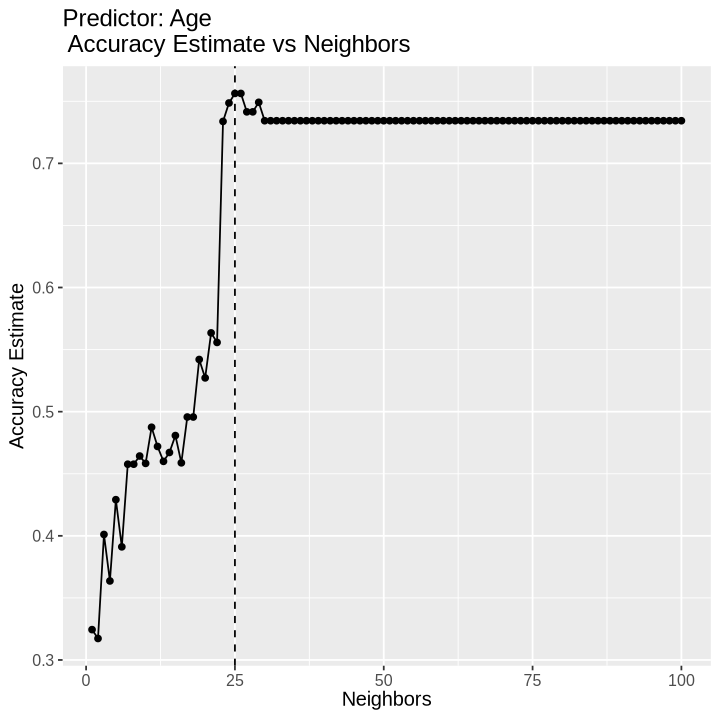

In [9]:
set.seed(1234) # Seed for possible recreation
options(repr.plot.width = 6, repr.plot.height = 6)

# Filtering metrics for just accuracy
age_accuracies <- knn_age_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
best_k_age <- age_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization.
accuracy_vs_k_age <- ggplot(age_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = best_k_age, linetype = "dashed") +
  labs(title = "Predictor: Age \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
accuracy_vs_k_age

**(Figure 5)** : _A line plot that visualizes how the classification accuracy of predicting `subscribe` changes as the number of neighbors (k-value) increases, using age as the sole predictor. The x-axis indicates the number of neighbors (from 1 to 100) in the KNN model, while the y-axis indicates the cross-validated accuracy estimate for each number of neighbors. The vertical dashed line indicates that the number of neighbors that yields the highest accuracy is 25._

In [10]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 25)
best_knn_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the testing data
knn_fit_age <- workflow() |>
  add_recipe(players_age_recipe) |>
  add_model(best_knn_spec_age) |>
  fit(data = players_testing)

# Predicting + binding predictions onto the testing data
players_age_test_prediction <- predict(knn_fit_age, players_testing) |>
    bind_cols(players_testing)

# Filtering for accuracy
players_age_test_prediction_acc <- players_age_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull()

# Confusion Matrix for this algorithm's performance on the testing data
players_age_test_prediction_conf <- players_age_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_age_test_prediction_conf

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     16   43

**(Figure 6)** : _The confusion matrix of the model with 25 neighbors using only Age as a predictor. The accuracy of this model on the testing data is 72.9%, the precision is 72.9% and the recall is 100%._

In [11]:
set.seed(1234) # Seed for possible recreation

# Recipe using played_hours to predict subscription using the training data + scaling predictors 
players_played_hours_recipe <- recipe(subscribe ~ played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation
knn_played_hours_results <- workflow() |>
    add_recipe(players_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

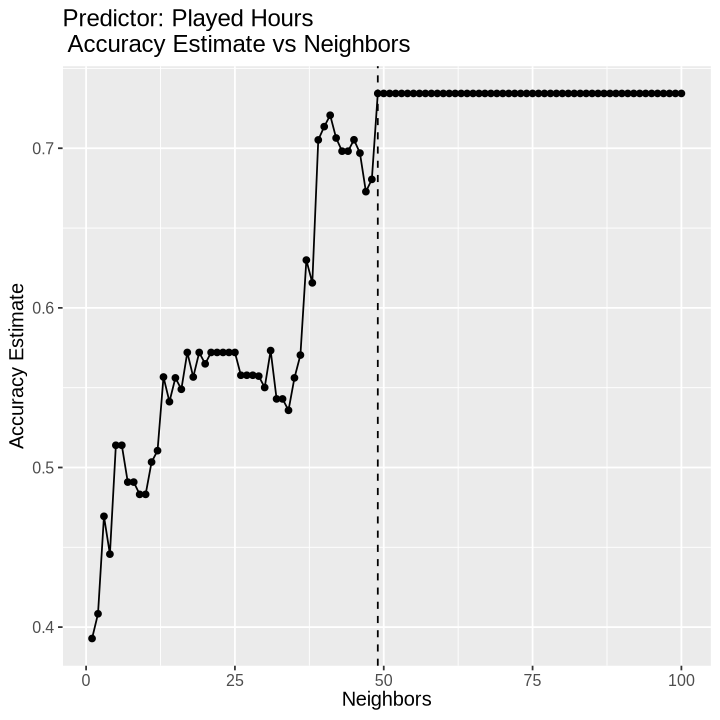

In [12]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
played_hours_accuracies <- knn_played_hours_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
best_k_played_hours <- played_hours_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization
accuracy_vs_k_played_hours <- ggplot(played_hours_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = best_k_played_hours, linetype = "dashed") +
  labs(title = "Predictor: Played Hours \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
accuracy_vs_k_played_hours

**(Figure 7)** : _A line plot that visualizes how the classification accuracy of predicting `subscribe` changes as the number of neighbors (k-value) increases, using played hours as the sole predictor. The x-axis indicates the number of neighbors (from 1 to 100) in the KNN model, while the y-axis indicates the cross-validated accuracy estimate for each number of neighbors. The vertical dashed line indicates that the number of neighbors that yields the highest accuracy is 49._

In [13]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 49)
best_knn_spec_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the testing data
knn_fit_played_hours <- workflow() |>
  add_recipe(players_played_hours_recipe) |>
  add_model(best_knn_spec_played_hours) |>
  fit(data = players_testing)

# Predicting + binding predictions onto the testing data
players_played_hours_test_prediction <- predict(knn_fit_played_hours, players_testing) |>
    bind_cols(players_testing)

# Filtering for accuracy
players_played_hours_test_prediction_acc <- players_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull()

# Confusion Matrix for this algorithm's performance on the testing data
players_played_hours_test_prediction_conf <- players_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_played_hours_test_prediction_conf

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     16   43

**(Figure 8)**: _The confusion matrix of the model with 49 neighbors using only played_hours as a predictor. The accuracy of this model on the testing data is 72.9%, the precision is 72.9% and the recall is 100%._

In [14]:
set.seed(1234) # Seed for possible recreation

# Recipe using age and played_hours to predict subscription using the training data + scaling predictors 
players_age_played_hours_recipe <- recipe(subscribe ~ Age + played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross-validation
knn_age_played_hours_results <- workflow() |>
    add_recipe(players_age_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

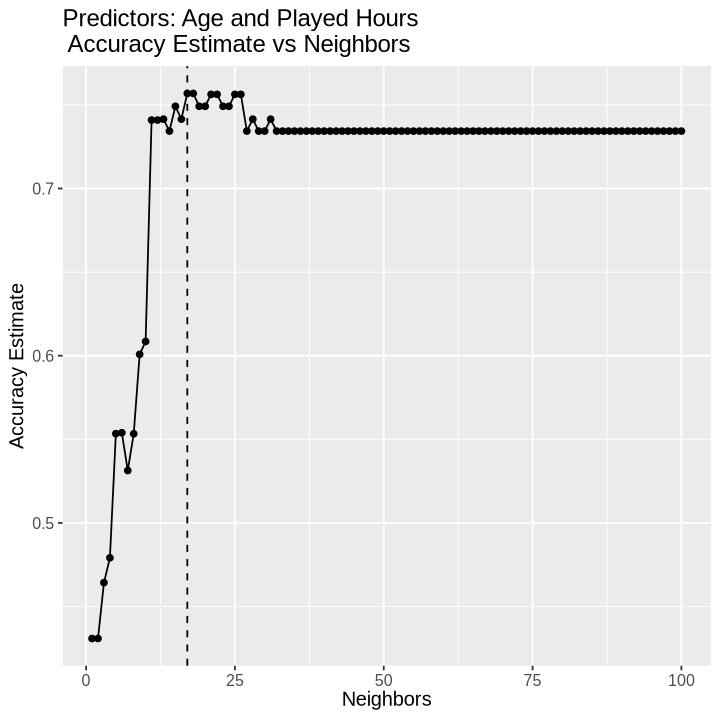

In [15]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
age_played_hours_accuracies <- knn_age_played_hours_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
best_k_age_played_hours <- age_played_hours_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization.
accuracy_vs_k_age_played_hours <- ggplot(age_played_hours_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = best_k_age_played_hours, linetype = "dashed") +
  labs(title = "Predictors: Age and Played Hours \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
accuracy_vs_k_age_played_hours

**(Figure 9)** : _A line plot that visualizes how the classification accuracy of predicting `subscribe` changes as the number of neighbors (k-value) increases, using age and played hours as predictors. The x-axis indicates the number of neighbors (from 1 to 100) in the KNN model, while the y-axis indicates the cross-validated accuracy estimate for each number of neighbors. The vertical dashed line indicates that the number of neighbors that yields the highest accuracy is 17._

In [16]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 17)
best_knn_spec_age_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the testing data
knn_fit_age_played_hours <- workflow() |>
  add_recipe(players_age_played_hours_recipe) |>
  add_model(best_knn_spec_age_played_hours) |>
  fit(data = players_testing)

# Predicting + binding predictions onto the testing data
players_age_played_hours_test_prediction <- predict(knn_fit_age_played_hours, players_testing) |>
    bind_cols(players_testing)

# Filtering for accuracy
players_age_played_hours_test_prediction_acc <- players_age_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull()

# Confusion Matrix for this algorithm's performance on the testing data
players_age_played_hours_test_prediction_conf <- players_age_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_age_played_hours_test_prediction_conf

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     16   43

**(Figure 10)** : _The confusion matrix of the model with 17 neighbors using Age and played_hours as predictors. The accuracy of this model on the testing data is 72.9%, the precision is 72.9% and the recall is 100%._

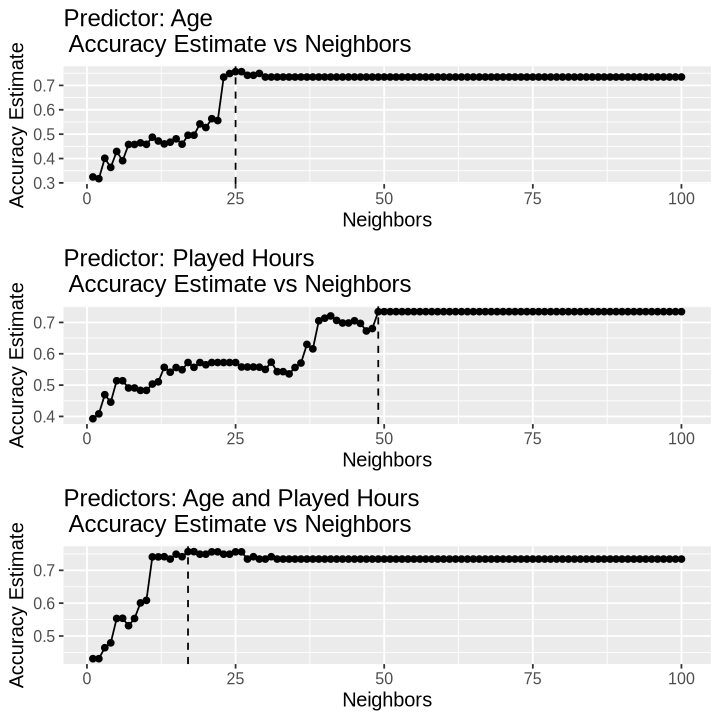

In [17]:
# Stacking Figure 5, Figure 7, and Figure 9
plot_grid(accuracy_vs_k_age, accuracy_vs_k_played_hours, accuracy_vs_k_age_played_hours, ncol = 1)

**(Figure 11)** : _The top graph is the relation between the number of neighbors and the accuracy of a model predicting subscription status using only age as a predictor (as seen in **Figure 5**). The middle graph is the relation between the number of neighbors and the accuracy of a model predicting subscription status using only played_hours as a predictor (as seen in **Figure 7**). The bottom graph is the relation between the number of neighbors and the accuracy of a model predicting subscription status using both age and played_hours as predictors (as seen in **Figure 9**)._

In [18]:
# Pulling the accuracy for the age predicting model
age_accuracy <- players_age_test_prediction_acc

# Pulling the accuracy for the played_hours predicting model
played_hours_accuracy <- players_played_hours_test_prediction_acc

# Pulling the accuracy for the age + played_hours predicting model
age_played_hours_accuracy <- players_age_played_hours_test_prediction_acc

# Creating tibble for each model's k-value and accuracy
accuracies <- tibble(predictors = c("Age", "played_hours", "Age_played_hours"),
                     k_value = c(best_k_age, best_k_played_hours, best_k_age_played_hours),
                     accuracy = c(age_accuracy, played_hours_accuracy, age_played_hours_accuracy))
accuracies

predictors,k_value,accuracy
<chr>,<int>,<dbl>
Age,25,0.7288136
played_hours,49,0.7288136
Age_played_hours,17,0.7288136


**(Figure 12)** : _This dataframe presents the best-performing number of neighbors (k-value) and cross-validated accuracy (accuracies) using the best-performing number of neighbors for K-Nearest Neighbors (KNN) models using different sets of predictors._

### Upsampling the data
The above method resulted in all the accuracies being the same across all three predictors. This might be due to a class imbalance in `subscribe`. In order to balance the data, upsampling was conducted.

In [19]:
set.seed(1234) # Seed for possible recreation

# Recipe for upsampling players dataframe
players_recipe_balance <- recipe(subscribe ~ ., data = players) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
  prep()

# Upsampling players dataframe
upsampled_players <- bake(players_recipe_balance, players)

In [20]:
set.seed(1234) # Seed for possible recreation

#Spitting the upsampled dataframe into training and testing sets 
unsampled_players_split <- initial_split(upsampled_players, prop = 0.7, strata = subscribe)
upsampled_players_training <- training(unsampled_players_split)
upsampled_players_testing <- testing(unsampled_players_split)

# Specifying the number of folds in our cross-validation + which variable we are predicting
upsampled_players_vfold <- vfold_cv(upsampled_players_training, v = 10, strata = subscribe)

In [21]:
# Checking Ratio of TRUE and FALSE in suscribe column in players
upsampled_players |>
  group_by(subscribe) |>
  summarize(n = n()) |>
  mutate(percent = 100*n/nrow(upsampled_players))

# Checking Ratio of TRUE and FALSE in suscribe column in training set
upsampled_players_training |>
  group_by(subscribe) |>
  summarize(n = n()) |>
  mutate(percent = 100*n/nrow(upsampled_players_training))

# Checking Ratio of TRUE and FALSE in suscribe column in testing set
upsampled_players_testing |>
  group_by(subscribe) |>
  summarize(n = n()) |>
  mutate(percent = 100*n/nrow(upsampled_players_testing))

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,142,50
TRUE,142,50


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,99,50
TRUE,99,50


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,43,50
TRUE,43,50


**(Figure 13)** : _The subscribe class ratio of the upsampled players data. The three dataframes show that the ratios for the upsampled players data (top), the training data (middle) and the testing data (bottom) all have 50% true observations and 50% false observations._

In [22]:
set.seed(1234) # Seed for possible recreation

# Recipe using Age to predict subscription using the upsampled training data + scaling predictors
upsampled_players_age_recipe <- recipe(subscribe ~ Age, data = upsampled_players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation.
upsampled_knn_age_results <- workflow() |>
    add_recipe(upsampled_players_age_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = upsampled_players_vfold, grid = k_vals) |>
    collect_metrics()

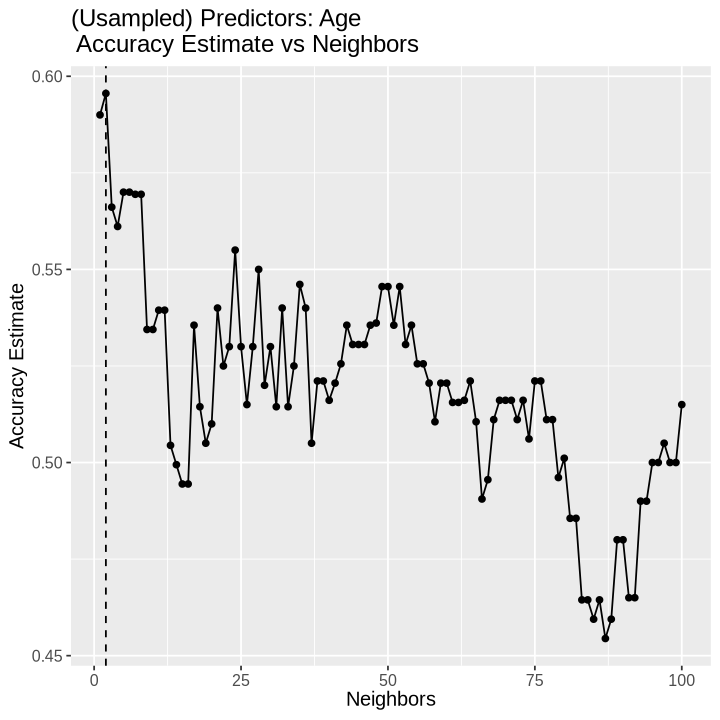

In [23]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
upsampled_age_accuracies <- upsampled_knn_age_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
upsampled_best_k_age <- upsampled_age_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization.
upsampled_accuracy_vs_k_age <- ggplot(upsampled_age_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = upsampled_best_k_age, linetype = "dashed") +
  labs(title = "(Usampled) Predictors: Age \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
upsampled_accuracy_vs_k_age

**(Figure 14)** : _A line plot that visualizes how the classification accuracy of predicting `subscribe` changes as the number of neighbors (k-value) increases, using Age as the sole predictor. The x-axis indicates the number of neighbors (from 1 to 100) in the KNN model, while the y-axis indicates the cross-validated accuracy estimate for each number of neighbors. The vertical dashed line indicates that the number of neighbors that yields the highest accuracy is two._

In [24]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 2)
upsampled_best_knn_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = upsampled_best_k_age) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the upsampled testing data
upsampled_knn_fit_age <- workflow() |>
  add_recipe(upsampled_players_age_recipe) |>
  add_model(upsampled_best_knn_spec_age) |>
  fit(data = upsampled_players_testing)

# Predicting + binding predictions onto the upsampled testing data
upsampled_players_age_test_prediction <- predict(upsampled_knn_fit_age, upsampled_players_testing) |>
    bind_cols(upsampled_players_testing)

# Filtering for accuracy
upsampled_players_age_test_prediction_acc <- upsampled_players_age_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull()

# Confusion Matrix for this algorithm's performance on the upsampled testing data
upsampled_players_age_test_prediction_conf <- upsampled_players_age_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
upsampled_players_age_test_prediction_conf

          Truth
Prediction FALSE TRUE
     FALSE    43   37
     TRUE      0    6

**(Figure 15)** : _The confusion matrix of the model with two neighbors using only Age as a predictor. The accuracy of this model on the testing data is 57.0%, the precision is 100% and the recall is 14.0%._

In [25]:
set.seed(1234) # Seed for possible recreation

# Recipe using played_hours to predict subscription using the upsampled training data + scaling predictors
upsampled_players_played_hours_recipe <- recipe(subscribe ~ played_hours, data = upsampled_players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation.
upsampled_knn_played_hours_results <- workflow() |>
    add_recipe(upsampled_players_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = upsampled_players_vfold, grid = k_vals) |>
    collect_metrics()

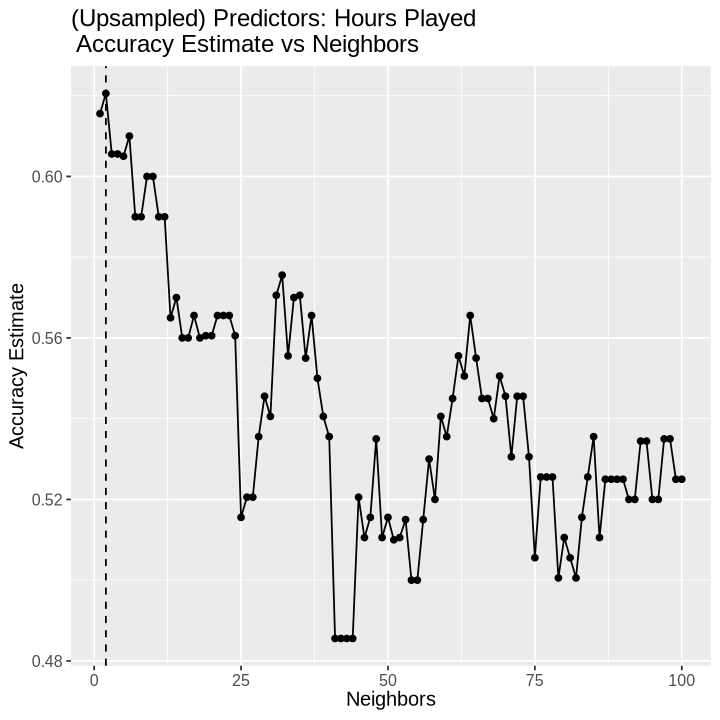

In [26]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
upsampled_played_hours_accuracies <- upsampled_knn_played_hours_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
upsampled_best_k_played_hours <- upsampled_played_hours_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization
upsampled_accuracy_vs_k_played_hours <- ggplot(upsampled_played_hours_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = upsampled_best_k_played_hours, linetype = "dashed") +
  labs(title = "(Upsampled) Predictors: Hours Played \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
upsampled_accuracy_vs_k_played_hours

**(Figure 16)** : _A line plot that visualizes how the classification accuracy of predicting `subscribe` changes as the number of neighbors (k-value) increases, using played_hours as the sole predictor. The x-axis indicates the number of neighbors (from 1 to 100) in the KNN model, while the y-axis indicates the cross-validated accuracy estimate for each number of neighbors. The vertical dashed line indicates that the number of neighbors that yields the highest accuracy is two._

In [27]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 2)
upsampled_best_knn_spec_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = upsampled_best_k_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the upsampled testing data
upsampled_knn_fit_played_hours <- workflow() |>
  add_recipe(upsampled_players_played_hours_recipe) |>
  add_model(upsampled_best_knn_spec_played_hours) |>
  fit(data = upsampled_players_testing)

# Predicting + binding predictions onto the upsampled testing data
upsampled_players_played_hours_test_prediction <- predict(upsampled_knn_fit_played_hours, upsampled_players_testing) |>
    bind_cols(upsampled_players_testing)

# Filtering for accuracy
upsampled_players_played_hours_test_prediction_acc <- upsampled_players_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull()

# Confusion Matrix for this algorithm's performance on the upsampled testing data
upsampled_players_played_hours_test_prediction_conf <- upsampled_players_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
upsampled_players_played_hours_test_prediction_conf

          Truth
Prediction FALSE TRUE
     FALSE    43   28
     TRUE      0   15

**(Figure 17)** : _The confusion matrix of the model with two neighbors using only played_hours as a predictor. The accuracy of this model on the testing data is 67.4%, the precision is 100% and the recall is 34.9%._

In [28]:
set.seed(1234) # Seed for possible recreation

# Recipe using Age and played_hours to predict subscription using the upsampled training data + scaling predictors
upsampled_players_age_played_hours_recipe <- recipe(subscribe ~ Age + played_hours, data = upsampled_players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation.
upsampled_knn_age_played_hours_results <- workflow() |>
    add_recipe(upsampled_players_age_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = upsampled_players_vfold, grid = k_vals) |>
    collect_metrics()

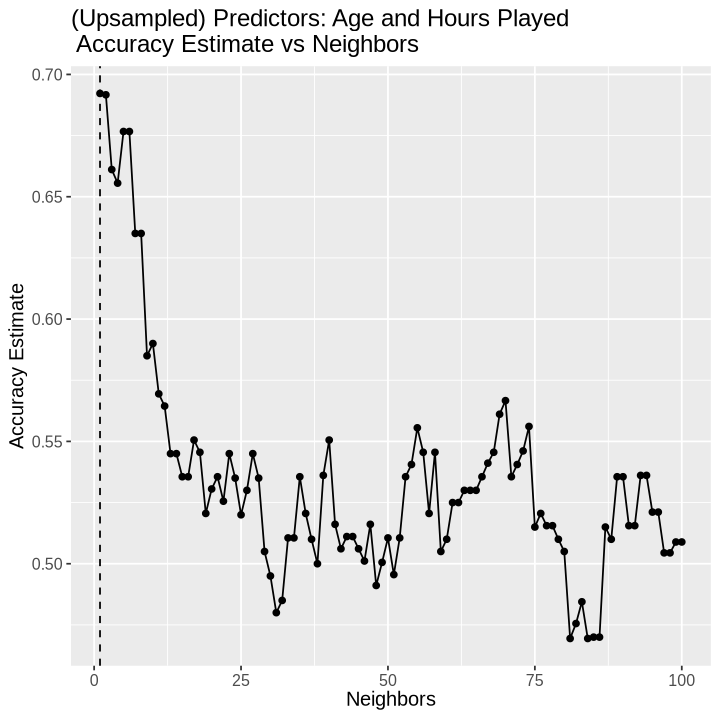

In [29]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
upsampled_age_played_hours_accuracies <- upsampled_knn_age_played_hours_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
upsampled_best_k_age_played_hours <- upsampled_age_played_hours_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization.
upsampled_accuracy_vs_k_age_played_hours <- ggplot(upsampled_age_played_hours_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = upsampled_best_k_age_played_hours, linetype = "dashed") +
  labs(title = "(Upsampled) Predictors: Age and Hours Played \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
upsampled_accuracy_vs_k_age_played_hours

**(Figure 18)** : _A line plot that visualizes how the classification accuracy of predicting `subscribe` changes as the number of neighbors (k-value) increases, using Age and played_hours as predictors. The x-axis indicates the number of neighbors (from 1 to 100) in the KNN model, while the y-axis indicates the cross-validated accuracy estimate for each number of neighbors. The vertical dashed line indicates that the number of neighbors that yields the highest accuracy is one._

In [30]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 1)
upsampled_best_knn_spec_age_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = upsampled_best_k_age_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the upsampled testing data
upsampled_knn_fit_age_played_hours <- workflow() |>
  add_recipe(upsampled_players_age_played_hours_recipe) |>
  add_model(upsampled_best_knn_spec_age_played_hours) |>
  fit(data = upsampled_players_testing)

# Predicting + binding predictions onto the upsampled testing data
upsampled_players_age_played_hours_test_prediction <- predict(upsampled_knn_fit_age_played_hours, upsampled_players_testing) |>
    bind_cols(upsampled_players_testing)

# Filtering for accuracy
upsampled_players_age_played_hours_test_prediction_acc <- upsampled_players_age_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull()

# Confusion Matrix for this algorithm's performance on the upsampled testing data
upsampled_players_age_played_hours_test_prediction_conf <- upsampled_players_age_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
upsampled_players_age_played_hours_test_prediction_conf

          Truth
Prediction FALSE TRUE
     FALSE    43   21
     TRUE      0   22

**(Figure 19)** : _The confusion matrix of the model with one neighbor using Age and played_hours as predictors. The accuracy of this model on the testing data is 75.6%, the precision is 100% and the recall is 51.2%._

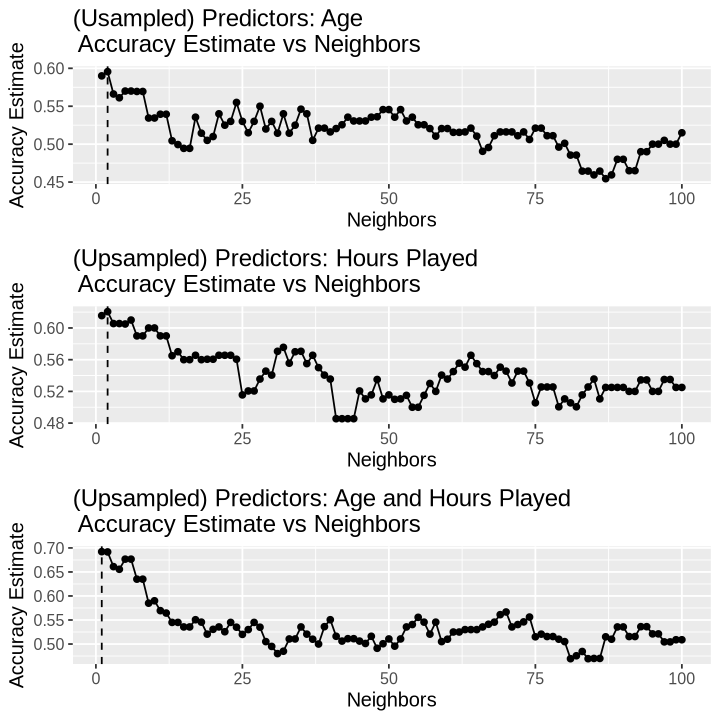

In [31]:
# Stacking Figure 14, Figure 16, and Figure 18
plot_grid(upsampled_accuracy_vs_k_age, upsampled_accuracy_vs_k_played_hours, upsampled_accuracy_vs_k_age_played_hours, ncol = 1)

**(Figure 20)** : _The top graph is the relation between the number of neighbors and the accuracy of a model trained on upsampled data predicting subscription status using only Age as a predictor (as seen in **Figure 14**). The middle graph is the relation between the number of neighbors and the accuracy of a model trained on upsampled data predicting subscription status using only played_hours as a predictor (as seen in **Figure 16**). The bottom graph is the relation between the number of neighbors and the accuracy of a model trained on upsampled data predicting subscription status using both Age and played_hours as predictors (as seen in **Figure 18**)._

In [32]:
# Pulling the accuracy for the upsampled age predicting model
upsampled_age_accuracy <- upsampled_players_age_test_prediction_acc

# Pulling the accuracy for the upsampled played_hours predicting model
upsampled_played_hours_accuracy <- upsampled_players_played_hours_test_prediction_acc

# Pulling the accuracy for the upsampled age and played_hours predicting model
upsampled_age_played_hours_accuracy <- upsampled_players_age_played_hours_test_prediction_acc

# Creating tibble for each upsampled model's k-value and accuracy
upsampled_accuracies <- tibble(predictors = c("Age", "played_hours", "Age_played_hours"),
                     upsampled_k_value = c(upsampled_best_k_age, upsampled_best_k_played_hours, upsampled_best_k_age_played_hours),
                     upsampled_accuracies = c(upsampled_age_accuracy, upsampled_played_hours_accuracy, upsampled_age_played_hours_accuracy))
upsampled_accuracies

predictors,upsampled_k_value,upsampled_accuracies
<chr>,<int>,<dbl>
Age,2,0.5697674
played_hours,2,0.6744186
Age_played_hours,1,0.7558140


**(Figure 21)** : _This dataframe presents the best-performing number of neighbors (k-value) and cross-validated accuracy (accuracies) using the best-performing number of neighbors for K-Nearest Neighbors (KNN) models trained on upsampled data using different sets of predictors._

### Results

Our previous KNN classification accuracies before upsampling helped us realize that there was bias in our data which made it so that all sets of predictors gave the same accuracy. After upsampling our data and performing KNN classification again on our 3 sets of predictors (just `Age`, just `played_hours`, and both `Age` and `played_hours`), we find that using both predictor variables give us the best accuracy in predicting which kinds of individuals will subscribe to the game-related newsletter. This accuracy, 75.6%, is even higher than the accuracy we got before upsampling our data, 72.9%, which suggests that our previous analyses were affected by class imbalance in `subscribe`. Therefore, using both predictor variables during KNN classification would give the most accurate predictions in the kinds of people that the research group should advertise their game-related newsletter to.

## Discussion

### Summary
To conduct our analysis, the most appropriate method to help address our specific question is KNN classification because there are two quantitative variables (`Age` and `played_hours`) used to predict a categorical variable (`subscribe`). To better understand the data, graphs were created to analyze the players.csv dataset. These graphs indicated that there was no distinct relationship between the age and played_hours predictors with respect to subscription (Fig. 1 and Fig. 2). The relationship between the predictors, `Age` and played_hours,  both individually and then together, were explored and analyzed based on its impact on game-related newsletter subscription. However, no clear relationship between the predictor variables and `subscribe` (Fig. 3), when predictor variables were considered separately and together, was found. When conducting KNN classification to predict the data, the ratio of subscribe, where `subscribe` is either TRUE or FALSE, was roughly the same between the original, training and testing datasets. After training the classification model, the accuracy of using only `Age`, only `played_hours` and `Age` and `played_hours` together, was found to be 72.9% across all three predictors (Fig. 12). As such, with all accuracies being the same, it was suspected that this was due to a class imbalance in `subscribe`, and `players.csv` was upsampled to create three additional KNN classifications. From the confusion matrices, using only `Age` as a predictor resulted in an accuracy of 57% (Fig. 15) and using only `played_hours` resulted in an accuracy of 67.4% (Fig. 17). The accuracy for using both `Age` and `played_hours` together was 75.6% (Fig 19). Therefore, based on this analysis, we can conclude that using `Age` together with `played_hours` results in a more accurate prediction of game-related newsletters as opposed to considering either predictor separately. However, a 75.6% accuracy is not exactly high when it comes to predicting subscriptions based on `Age` and `played_hours`. Further analysis would be needed to verify if other factors would increase this accuracy.

### Expectation 
The results from our analysis were somewhat what we expected. We expected `Age` and `played_hours` to both individually have moderately high accuracy predictions in newsletter subscription. However, as mentioned above, the accuracies for both predictors separately were moderately low. As well, based on raw data before any KNN classification was conducted, there was no clear relationship between either predictor variable, taken separately, with respect to subscribe. We found that with our original dataset, `player.csv`, the accuracies were the same, but by upsampling the dataset we found that using both predictor variables gave the higher accuracy than the predictor variables individually. Thus, this suggests a possibility of considering both predictor variables together to give a better accuracy. This was what we expected, and as shown from our analysis, both variables taken together offered a higher accuracy compared to the variables separately. However, we expected this accuracy to be higher, with a clearer relationship between the quantitative variables and the categorical variable subscribe. A reason for this is the class imbalance that we did not initially account for, which could cause KNN classification to not perform as well.

### Impact 
Based on our findings, we cannot confidently conclude which quantitative variables are most predictive of an individual subscribing to a game-related newsletter. Given our conclusion that there is no clear relationship between the predictor variables and the classifier, this could help direct researchers in answering the broad question by considering other variables. This could lead to further and more exhaustive data collection and potentially looking into other variables to try to answer the broad question. From the stakeholders perspective, these findings could be useful for the newsletters in catering content towards the groups (when considering both `Age` and `played_hours` together) that are most likely to subscribe to their newsletter. Since we found that the accuracy of subscription based on `Age` and `played_hours` together is 75.6%, this could help provide more insight in understanding the effects of our variables. For stakeholders specifically, this could allow them to cater their content towards specific groups. Gaining access to these results could help the newsletter from an engagement perspective by including content that those groups might like to see. While our findings are not significant, it provides a good start on understanding whether specific variables can increase the likelihood of game-related newsletter subscription, and can lead to further future research to understand these factors better. 

### Future Questions
Based on our findings, there is a moderate accuracy in predicting the effects of `Age`and `played_hours` on `subscribe` with no clear correlation between these variables. As such, it is highly likely that there are other factors that could better predict, with an even higher accuracy, the likelihood of subscribing to a game-related newsletter. One question that could be investigated in the future could be whether `experience` and `played_hours` could predict newsletter subscription. This could lead to findings as we would gain more insight on the effects of engagement and investment in MineCraft and its influence on newsletter subscription. On that note, it would also be interesting to explore the other variables in the dataset, whether individually or in combination. Taken together, this would allow us to observe which variable(s) in the dataset provide the highest accuracy in predicting newsletter subscription. As well further analyses could be conducted on other factors that were not collected at the time of data collection, and their effects on newsletter subscription could be evaluated. Both of these questions will allow the researchers as well as the newsletters to gain more insight while addressing the broad question we have chosen.

## Conclusion
From our analysis and using KNN classification, we aimed to predict the effects of `Age` and `played_hours` on subscription to a game-related newsletter. In terms of predictive performance, the accuracy when considering `Age` and `played_hours` together was found to be 75.6%, with accuracies for both variables being lower (57% and 67.4% respectively). The results of our findings offer a good starting point in understanding how various factors affect newsletter subscription, and could lead to future studies to better understand this.